In [94]:
import numpy as np
from stats import LinearSolveStats, TimeStepStats
from stats import TimeStepStats
from matplotlib import pyplot as plt
from plot_utils import *

data = load_data("../stats/fpm_0_open_solver_1.json")

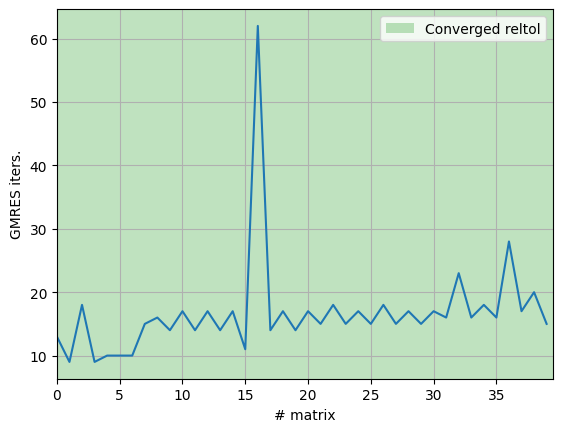

In [95]:
# %matplotlib ipympl
color_converged_reason(data)
plt.plot(get_gmres_iterations(data))
plt.ylabel('GMRES iters.')
plt.xlabel('# matrix')
# plt.yscale('log')
plt.legend()

In [96]:
mat_idx = 14
get_gmres_iterations(data)[mat_idx]

17

In [97]:
from plot_utils import *

mat, rhs = load_matrix_rhs(data, mat_idx)

In [98]:
import porepy as pp
import numpy as np
from mat_utils import *
from plot_utils import *
from fpm_0 import make_model
from pp_utils import make_row_col_dofs, make_reorder_contact

model = make_model()
model.prepare_simulation()

model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model._initialize_solver()
eq_dofs, var_dofs = make_row_col_dofs(model)

reorder = make_reorder_contact(model)
mat = mat[reorder]

# model.assemble_linear_system()
# mat, rhs = model.linear_system
model.linear_system = mat, rhs
perm_mat, prec_orig = model._prepare_solver()

Solve  took: 0.1


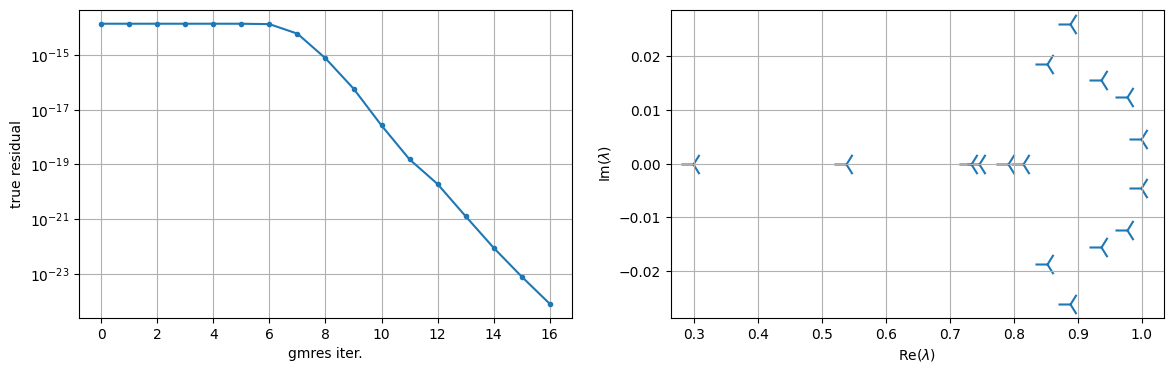

In [99]:
solve_petsc(perm_mat.mat, prec_orig, rhs=perm_mat.local_rhs(rhs))

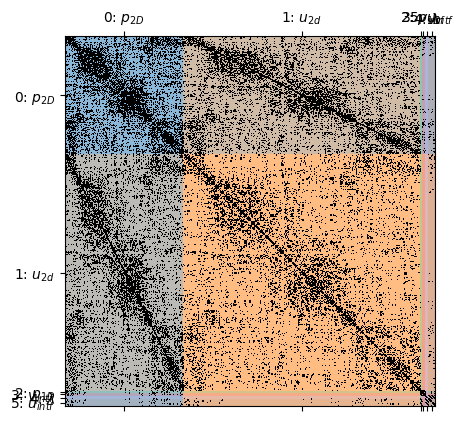

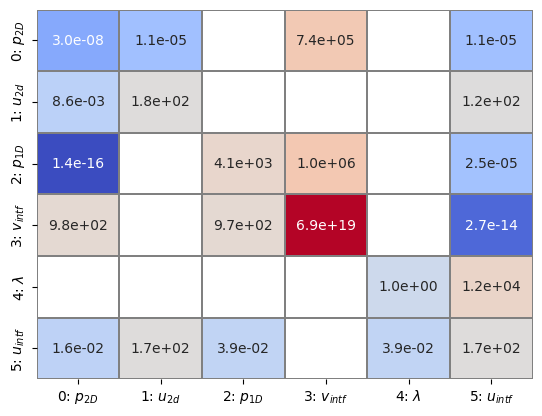

In [100]:
from block_matrix import BlockMatrixStorage

J = BlockMatrixStorage(
    mat=mat,
    row_idx=model.eq_dofs,
    col_idx=model.var_dofs,
    groups_row=model._equation_groups,
    groups_col=model._variable_groups,
    group_row_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$'],
    group_col_names=[r'$p_{2D}$', r'$u_{2d}$', r'$p_{1D}$', r'$v_{intf}$', r'$\lambda$', '$u_{intf}$']
)
J[:].color_spy()
J[:].plot_max()
# J[:].matshow()

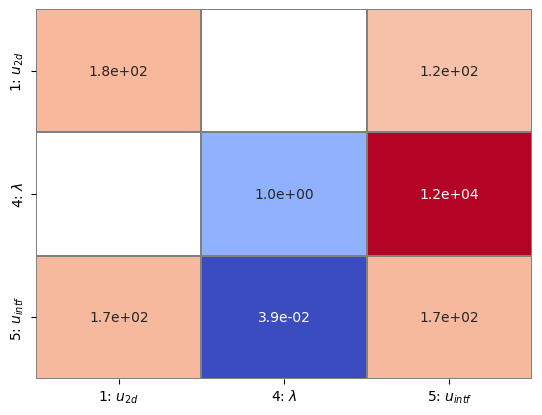

In [101]:
J_mech = J[[1,4,5]]
J_mech.plot_max()


Solve  took: 0.03


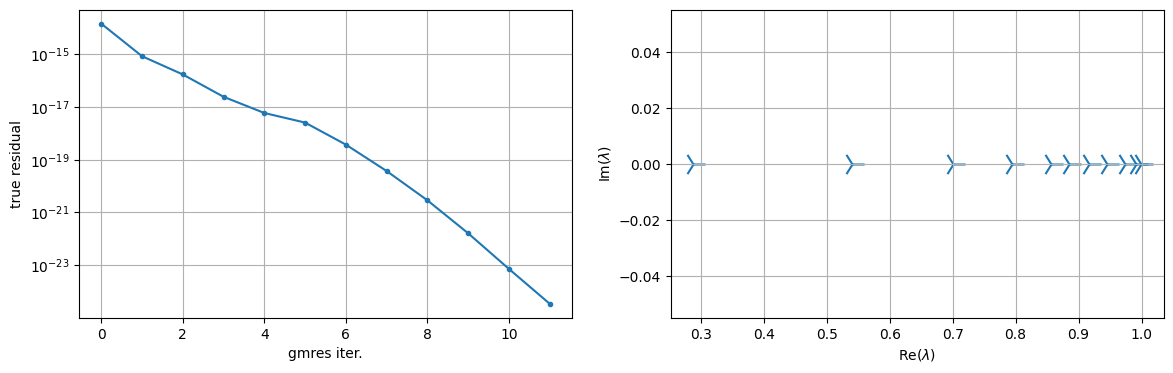

In [102]:
from block_matrix import SolveSchema, make_solver
from pp_utils import get_fixed_stress_stabilization

schema_1 = SolveSchema(
    groups=[1],
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
)

schema_45_1 = SolveSchema(
    groups=[4, 5],
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

/home/porepy/simulations/plot_utils.py:101: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


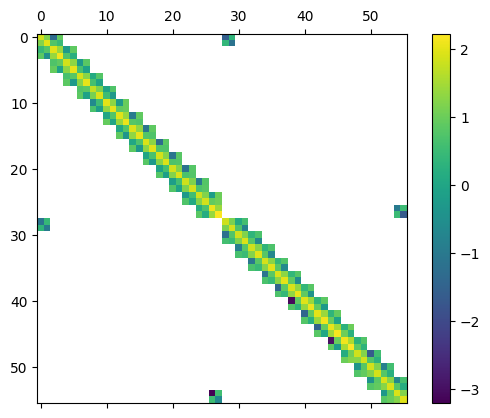

In [103]:
# J_mech[[5]].color_spy()
J_mech[[5]].matshow()

Solve  took: 0.0


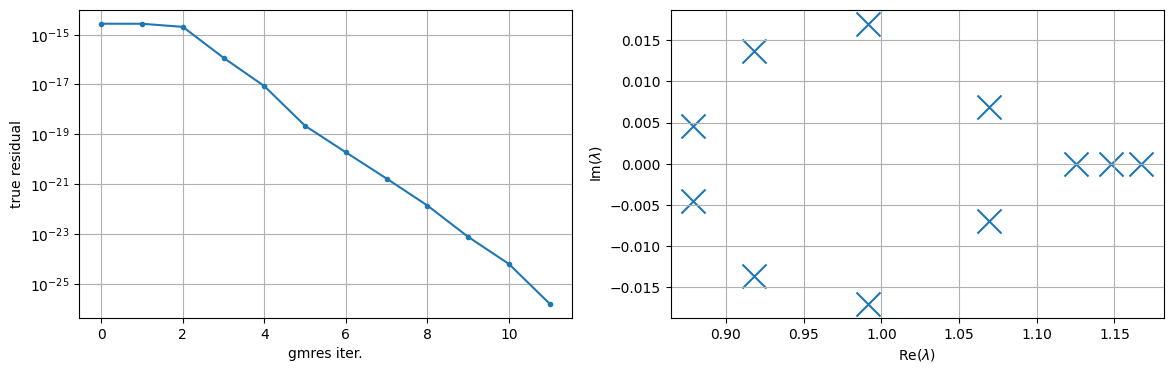

In [104]:
schema_5_4 = SolveSchema(
    groups=[5],
    # solve='direct',
    invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(abs(bmat.mat)) / 6,

    complement=SolveSchema(
        groups=[4],
        # solve=lambda bmat: inv_block_diag_2x2(bmat.mat),
    )
)

mat_permuted, prec = make_solver(schema=schema_5_4, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Note: It's not good enough to just take a diagonal approximation of J55

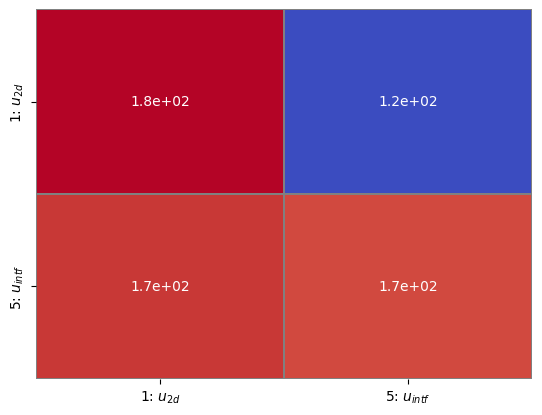

In [105]:
J[[1, 5]].plot_max()

Solve  took: 0.27
PETSc Converged Reason: -5


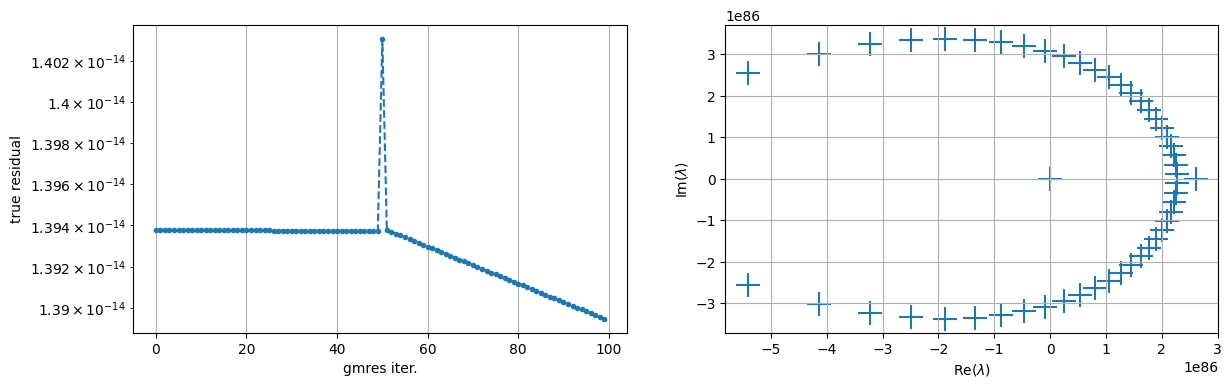

In [106]:
schema_5_4_1 = SolveSchema(
    groups=[5],
    solve='direct',
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    # invertor=lambda bmat: extract_rowsum_inv(bmat.mat),
    invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    # invertor=lambda bmat: inv_lu(bmat.mat),

    complement=SolveSchema(
        groups=[4],
        # solve=lambda bmat: inv_block_diag_2x2(bmat.mat[reorder])[:, reorder_inv],

        complement=schema_1,
    ),
    # complement=schema_1
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

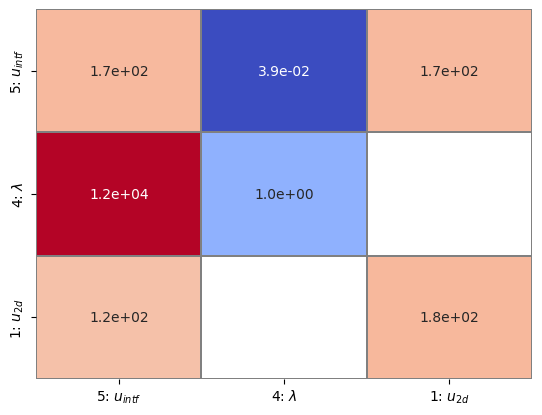

In [107]:
mat_permuted.plot_max()

/home/porepy/simulations/plot_utils.py:101: RuntimeWarning: divide by zero encountered in log10
  mat = np.log10(abs(mat))


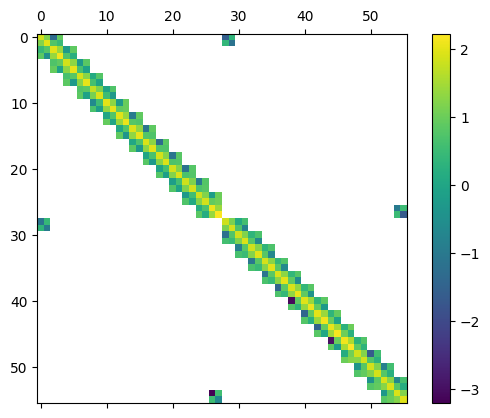

In [108]:
J55 = J[[5]].mat
plot_mat(J55, log=True)

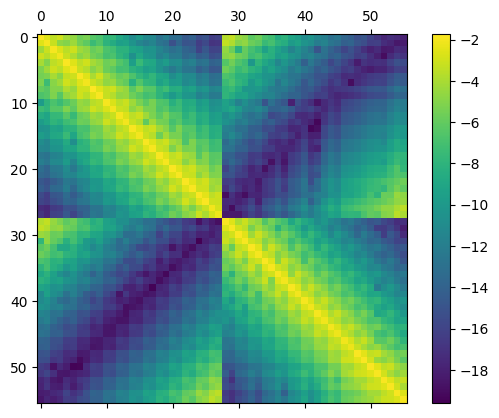

In [109]:
plot_mat(inv(J55))

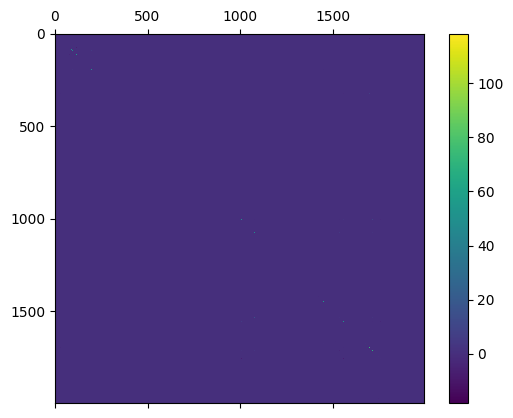

In [110]:
stab = J[1, 5].mat @ inv(J[5, 5].mat) @ J[5, 1].mat
plot_mat(stab, log=False)

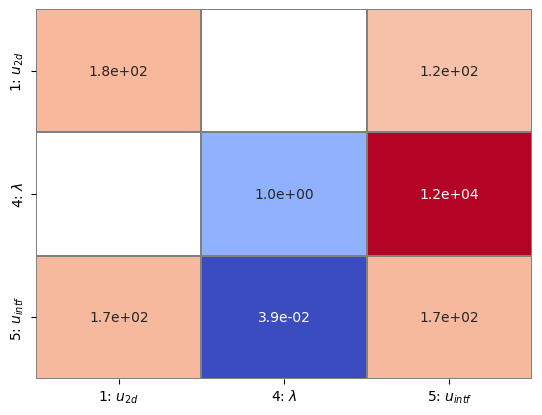

In [111]:
J_mech.plot_max()

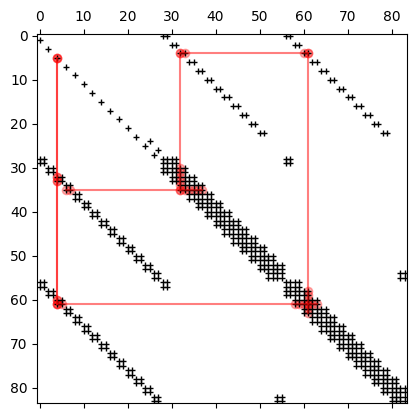

In [112]:
# %matplotlib tk


tmp = J_mech[[4, 5]].mat
spy(tmp, show=False)

row_start = 61
col_start = 61
recursion = 4

def connect_vertices(mat, mat_t, row_start, col_start, recursion=1, transposed=False):
    if recursion == 0:
        return
    
    mat_t = mat_t.tocsr()
    mat = mat.tocsr()    
    cols = mat[row_start].indices
    if not transposed:
        plt.plot([min(cols), max(cols)], [row_start, row_start], alpha=0.5, color='red')
        plt.scatter(cols, [row_start] * len(cols), color='red', alpha=0.3)
    else:
        plt.plot([row_start, row_start], [min(cols), max(cols)], alpha=0.5, color='red')
        plt.scatter([row_start] * len(cols), cols, color='red', alpha=0.3)

    col = cols[np.argmax(abs(cols - col_start))]
    connect_vertices(mat_t, mat, row_start=col, col_start=row_start, recursion=recursion-1, transposed=not transposed)

connect_vertices(tmp, tmp.T, row_start=row_start, col_start=col_start, recursion=recursion)
connect_vertices(tmp.T, tmp, row_start=col_start, col_start=row_start, recursion=recursion, transposed=True)

In [113]:
matrix = model.mdg.subdomains()[0]
fracture = model.mdg.subdomains()[1]
intf = model.mdg.interfaces()[0]

secondary_to_mortar = intf.secondary_to_mortar_avg(nd=1).tocsc()
mortar_to_primary = intf.mortar_to_primary_avg(nd=1).tocsc()
faces_to_cells = matrix.cell_faces.T.tocsc()

secondary_to_mortar.eliminate_zeros()
mortar_to_primary.eliminate_zeros()
faces_to_cells.eliminate_zeros()

frac_cells = [1]
intf_cells = secondary_to_mortar[:, frac_cells].indices
print(f'{intf_cells = }')
mat_faces = mortar_to_primary[:, intf_cells].indices
print(f'{mat_faces = }')
mat_cells = faces_to_cells[:, mat_faces].indices
print(f'{mat_cells = }')

intf_cells = array([ 1, 15], dtype=int32)
mat_faces = array([ 565, 1539], dtype=int32)
mat_cells = array([856,  47], dtype=int32)


In [114]:
def make_reorder(num_dofs, nd=2):
    assert nd == 2
    reorder = np.zeros(num_dofs, dtype=int)
    half = reorder.size // 2
    reorder[1::2] = np.arange(half)
    reorder[::2] = np.arange(half) + half
    return reorder

def make_mat_2d(faces_to_cells):
    faces_to_cells_2d = scipy.sparse.block_diag([faces_to_cells] * 2, format=faces_to_cells.format)

    reorder_row = make_reorder(faces_to_cells_2d.shape[0])
    reorder_col = make_reorder(faces_to_cells_2d.shape[1])

    faces_to_cells_2d = faces_to_cells_2d[reorder_row]
    faces_to_cells_2d = faces_to_cells_2d[:, reorder_col]
    return faces_to_cells_2d

In [115]:
secondary_to_mortar = intf.secondary_to_mortar_avg(nd=2).tocsc()
mortar_to_primary = intf.mortar_to_primary_avg(nd=2).tocsc()
faces_to_cells = make_mat_2d(matrix.cell_faces.T).tocsc()

secondary_to_mortar.eliminate_zeros()
mortar_to_primary.eliminate_zeros()
faces_to_cells.eliminate_zeros()

frac_cells = [0, 1]
intf_cells = secondary_to_mortar[:, frac_cells].indices
print(f'{intf_cells = }')
mat_faces = mortar_to_primary[:, intf_cells].indices
print(f'{mat_faces = }')
mat_cells = faces_to_cells[:, mat_faces].indices
print(f'{mat_cells = }')

frac_to_mat_cells = faces_to_cells @ mortar_to_primary @ secondary_to_mortar

intf_cells = array([ 0, 28,  1, 29], dtype=int32)
mat_faces = array([   6, 3074,    7, 3075], dtype=int32)
mat_cells = array([1076,    4, 1077,    5], dtype=int32)


In [149]:
def extract_submat(mat, i, j):
    i, j = np.meshgrid(i, j, sparse=True, indexing="ij")
    return mat[i, j].toarray()


matrix = model.mdg.subdomains()[0]
fracture = model.mdg.subdomains()[1]
intf = model.mdg.interfaces()[0]

secondary_to_mortar = intf.secondary_to_mortar_avg(nd=2).tocsc()
mortar_to_primary = intf.mortar_to_primary_avg(nd=2).tocsc()
faces_to_cells = make_mat_2d(matrix.cell_faces.T).tocsc()

secondary_to_mortar.eliminate_zeros()
mortar_to_primary.eliminate_zeros()
faces_to_cells.eliminate_zeros()


J11 = J[1, 1].mat
J44 = J[4, 4].mat
J55 = J[5, 5].mat
J54 = J[5, 4].mat
J45 = J[4, 5].mat
J15 = J[1, 5].mat
J51 = J[5, 1].mat


def build_local_stabilization(frac_cell_id, build_schur=True):
    frac_cells = [frac_cell_id * 2, frac_cell_id * 2 + 1]
    intf_cells = secondary_to_mortar[:, frac_cells].indices
    mat_cells = frac_to_mat_cells[:, frac_cells].indices

    j44 = extract_submat(J44, frac_cells, frac_cells)
    j55 = extract_submat(J55, intf_cells, intf_cells)
    j45 = extract_submat(J45, frac_cells, intf_cells)
    j54 = extract_submat(J54, intf_cells, frac_cells)
    j_vert = extract_submat(J15, mat_cells, intf_cells)
    j_hor = extract_submat(J51, intf_cells, mat_cells)

    j_local = bmat(
        [
            [j44, j45],
            [j54, j55],
        ]
    )
    j_local_inv = inv(j_local)


    if build_schur:
        res = scipy.sparse.lil_matrix(J11.shape)
        stab_local = -j_vert @ j_local_inv[2:, 2:] @ j_hor
        i, j = np.meshgrid(mat_cells, mat_cells, sparse=True, indexing="ij")
        res[i, j] = stab_local
        return res
    else:
        res = scipy.sparse.lil_matrix(J[[4,5]].shape)
        frac_intf_cells = np.concatenate([frac_cells, J44.shape[0] + intf_cells])
        i, j = np.meshgrid(frac_intf_cells, frac_intf_cells, sparse=True, indexing="ij")
        res[i, j] = j_local_inv
        return res

def build_mechanics_stabilization(build_schur=True):
    shape = J11.shape if build_schur else J[[4, 5]].shape
    result = scipy.sparse.lil_matrix(shape)
    for i in range(fracture.num_cells):
        result += build_local_stabilization(i, build_schur=build_schur)
    return result.tocsr()

Solve  took: 0.05


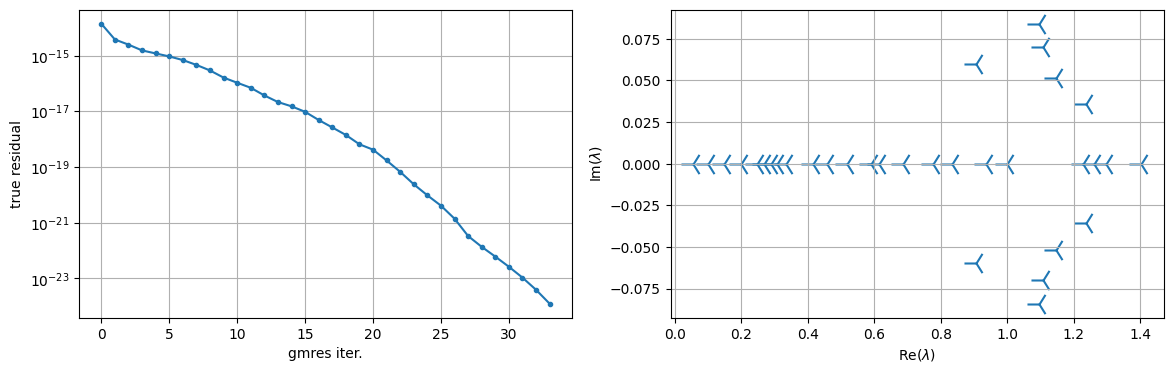

In [150]:
schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve='direct',
    invertor=build_mechanics_stabilization,
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Solve  took: 0.19
PETSc Converged Reason: -5


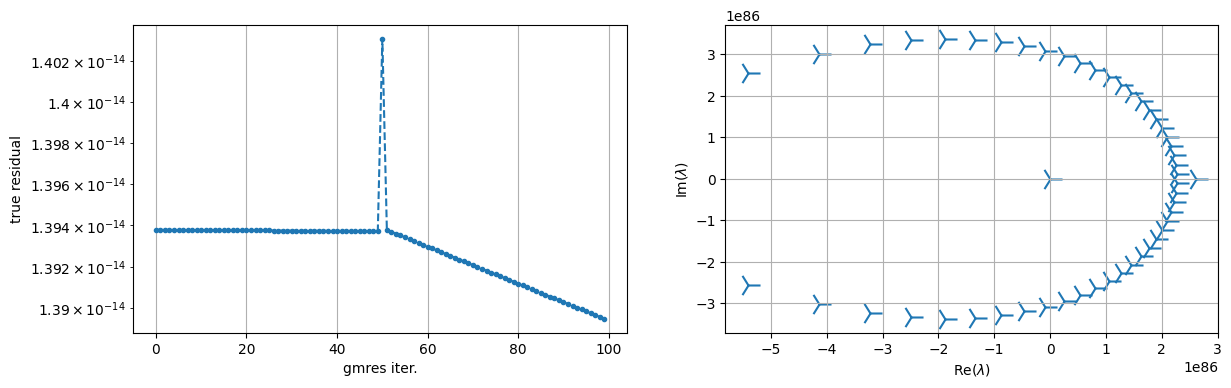

In [151]:
schema_5_4_1 = SolveSchema(
    groups=[5],
    solve='direct',
    invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
    complement=SolveSchema(
        groups=[4],
        solve='direct',
        invertor=lambda bmat: inv_block_diag_2x2(bmat.mat),
        complement=schema_1,
    ),
)

mat_permuted, prec = make_solver(schema=schema_5_4_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

# How to solve blocks 4 and 5 not by a direct solver?

Solve  took: 0.0


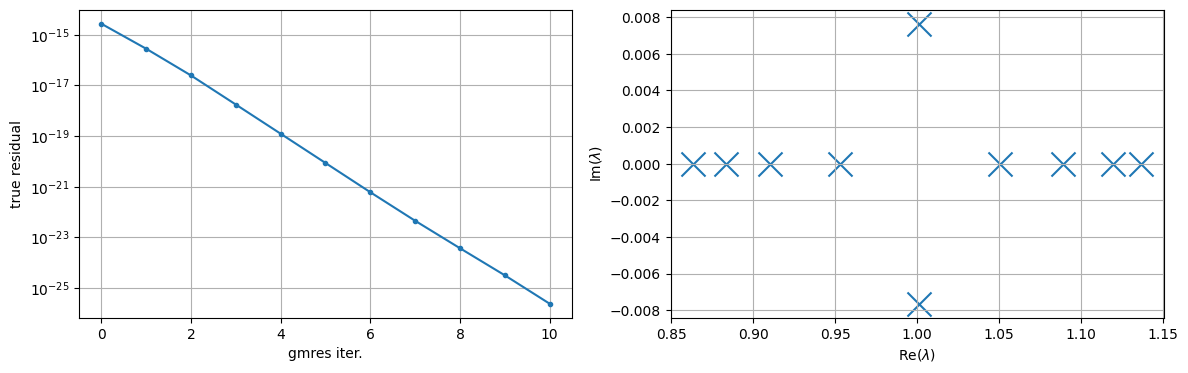

In [152]:
schema_45 = SolveSchema(
    groups=[4, 5],
    solve=lambda bmat: build_mechanics_stabilization(build_schur=False),
)

mat_permuted, prec = make_solver(schema=schema_45, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

Solve  took: 0.04


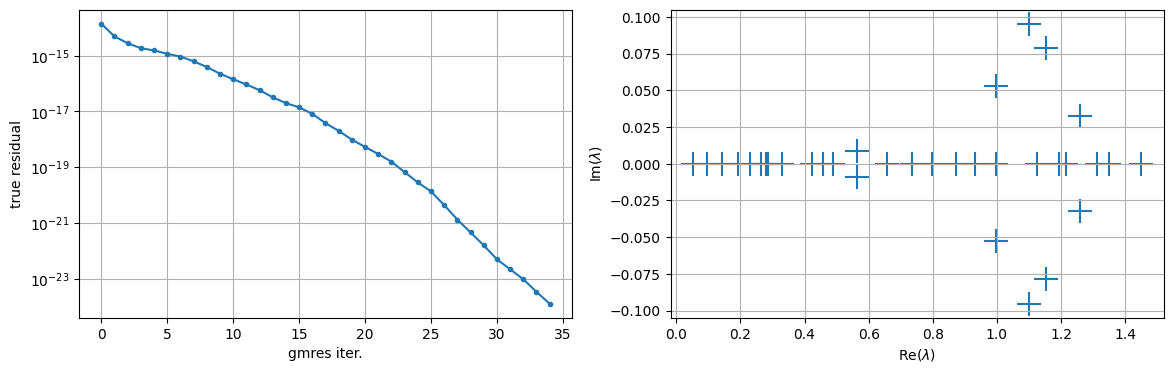

In [153]:
schema_45_1 = SolveSchema(
    groups=[4, 5],
    solve=lambda bmat: build_mechanics_stabilization(build_schur=False),
    invertor=build_mechanics_stabilization,
    invertor_type='physical',
    complement=schema_1,
)

mat_permuted, prec = make_solver(schema=schema_45_1, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

# Full matrix

In [146]:
from pp_utils import get_fixed_stress_stabilization_nd

def fill_empty_blocks(mat):
    empty_0 = scipy.sparse.csr_matrix(J[[0]].shape)
    empty_2 = scipy.sparse.csr_matrix(J[[2]].shape)
    return scipy.sparse.block_diag([empty_0, empty_2, mat]).tocsr()

schema_02 = SolveSchema(
    groups=[0, 2],
    # solve=lambda bmat: PetscAMGFlow(bmat.mat),
    solve='direct'
)

solve_1_02 = SolveSchema(
    groups=[1],
    # complement=schema_02,
    invertor=lambda: get_fixed_stress_stabilization_nd(model),
    invertor_type="physical",

    # invertor='direct',
    
    solve=lambda bmat: PetscAMGMechanics(dim=model.nd, mat=bmat.mat),
    # solve='direct'
)

schema_45_1_02 = SolveSchema(
    groups=[4, 5],
    # solve=lambda bmat: build_mechanics_stabilization(build_schur=False),
    invertor=lambda: fill_empty_blocks(build_mechanics_stabilization()),
    # invertor=lambda: build_mechanics_stabilization(),
    invertor_type='physical',
    complement=solve_1_02,
)

schema_3_45_1_02 = SolveSchema(
    groups=[3],
    # solve=lambda bmat: PetscILU(mat=bmat.mat, factor_levels=1),
    # invertor=lambda bmat: extract_diag_inv(bmat.mat),
    complement=schema_45_1_02,

    # only_complement=True
)

mat_permuted, prec = make_solver(schema=schema_3_45_1_02, mat_orig=J)
solve_petsc(mat_permuted.mat, prec, mat_permuted.local_rhs(rhs))

ValueError: inconsistent shapes